In [70]:
SEARCH_TERM = "Trump"
TWEETS_COUNT = 300
TIME_LIMIT = 120



import keys
import os
from credentials import *
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

dir_path = os.getcwd()
dir_path_data = dir_path + "/Data/"


consumer_key = keys.consumer_key
consumer_secret = keys.consumer_secret
access_token = keys.access_token
access_secret = keys.access_secret


print(consumer_key)
print(consumer_secret)
print(access_token)
print(access_secret)


print(dir_path)
print(dir_path_data)

 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)




cVmcGejdV64dB6NO1c6GrcEl3
iV8ol6vIW8iWizWZTzz1iso2Y5NKD5oxScUuDT1KBnUt1JZMVd
402517090-4WtXj9f1BlfdKCGq9MdbJsFl4XjogfnfFfCp2TAu
OFNqlBGawO9tLLS5PDlaYmZxZvZGdf7hjsI5yKthbaW9G
C:\sjsu-git\ML_Project
C:\sjsu-git\ML_Project/Data/


In [71]:
# Before running this code
# make a directory named Data and provide the path of the directory at INPUT_DATAPATH
# set SEARCH_TERM as what you would like to search from twitter "ex: apple"
# which would produce the list of tweets for the term "apple" 
# and also store the twitter data into the file stream_apple.json in the directory of INPUT_DATAPATH


from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import string
import json
import time
import os


class MyListener(StreamListener):
    """Custom StreamListener for streaming data."""

    def __init__(self, data_dir, query, time_limit):
        query_fname = ''.join(convert_valid(one_char) for one_char in query)
        self.start_time = time.time()
        self.limit = TIME_LIMIT
        self.outfile = "%s/stream_%s.json" % (data_dir, query_fname)
        
    def on_data(self, data):
        # removes if a file already exists with same name and creates new file and writes into that
        
        if os.path.exists(self.outfile):
            if os.path.getsize(self.outfile) > 2**20 * 2**10: # 1MB
                os.remove(self.outfile)
        with open(self.outfile,'a') as f:
            try:
                f.writelines(data.strip("\n"))

                if (time.time() - self.start_time) > self.limit:
                    print('WRITE COMPLETE')
                    time.sleep(1)
                    f.close()
                    return False
                return True

            except BaseException as e:
                print("Error on_data: %s" % str(e))
                time.sleep(5)


    def on_error(self, status):
        print(status)
        return True

    
def convert_valid(one_char):
    """Convert a character into '_' if invalid.
    Arguments:
        one_char -- the char to convert
    Return:
        Character -- converted char
    """
    valid_chars = "-_.%s%s" % (string.ascii_letters, string.digits)
    if one_char in valid_chars:
        return one_char
    else:
        return '_'
 


In [72]:
twitter_stream = Stream(auth, MyListener(dir_path_data, SEARCH_TERM, TIME_LIMIT)) #calling stream function to stream in live data
twitter_stream.filter(track=[SEARCH_TERM]) # filters data based on search term on storing

WRITE COMPLETE


In [73]:
from nltk.tokenize import word_tokenize, TweetTokenizer
import re
import operator 
import json
from collections import Counter
from nltk.corpus import stopwords
import string
from nltk import bigrams 
from collections import defaultdict
import nltk

com = defaultdict(lambda : defaultdict(int))
    
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'RT', ':', ',', '’',
                                                   'i\'m', '…', '...', 'a', 'b', 'c'
                                                  'd','g','j','m','p','s','v','y',
                                                  'e','h','k','n','q','t','w','z',
                                                  'f','i','l','o','r','u','x', 'http', 'https']    

      

tknzr = TweetTokenizer()
num_of_tweets = 0
tweets = []
original_tweets = []
fname = dir_path_data +'/stream_'+SEARCH_TERM+'.json'
with open(fname, 'r') as f:
    count_all = Counter()
    
    for line in f:
        num_of_tweets += 1
        tweet = json.loads(line)
        # Create a list with all the terms
        original = ''
        if 'extended_tweet' in tweet:
            terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
            original = tweet.get('extended_tweet').get('full_text')
            
        elif 'retweeted_status' in tweet:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['retweeted_status']['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet.get('retweeted_status').get('extended_tweet').get('full_text')
            except:
                pass
        else:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet['text']
            except:
                pass
        
#         print(original)
        tweets.append(terms)
        original_tweets.append(original)
        terms_bigram = list(nltk.bigrams(terms))
        
#         print(terms)
#         print(terms_bigram)

        # Build co-occurrence matrix
        for i in range(len(terms)-1):            
            for j in range(i+1, len(terms)):
                w1, w2 = sorted([terms[i], terms[j]])                
                if w1 != w2:
                    com[w1][w2] += 1
    
        # Update the counter
        count_all.update(terms_bigram)
        
# Print the first 5 most frequent words
# print(count_all.most_common(10))


original_tweets = list(filter(None, original_tweets))
# every single tweet vocab put into a list
flat_list = [term for tweet in tweets for term in tweet ]
hashtags_list = [hasht for hasht in flat_list if hasht.startswith('#')]

all_terms_dist = nltk.FreqDist(flat_list)
hash_terms_dist = nltk.FreqDist(hashtags_list)


print(all_terms_dist.most_common(10))

# print(count_all.most_common())


com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:10])

print(num_of_tweets)


'''
Bigrams
A collocation is a sequence of words that occur together unusually often. 
Thus red wine is a collocation, whereas the wine is not. 
A characteristic of collocations is that they are resistant to substitution
with words that have similar senses; for example, maroon wine sounds definitely odd.
'''

''''''

[('Trump', 3785), ('”', 543), ('“', 536), ('President', 430), ('get', 372), ('like', 366), ('merger', 361), ('Donald', 349), ('Obama', 330), ('people', 304)]
[(('🇸', '🇺'), 1813), (('「', '」'), 824), (('“', '”'), 802), (('Trump', '”'), 592), (('Trump', '“'), 587), (('Donald', 'Trump'), 458), (('Trump', 'like'), 445), (('Trump', 'merger'), 415), (('President', 'Trump'), 412), (('Obama', 'Trump'), 395)]
4381


''

In [74]:
import math
from nltk.corpus import opinion_lexicon


# n_docs is the total n. of tweets
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))
 
for term, n in all_terms_dist.most_common():
    p_t[term] = n / num_of_tweets
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / num_of_tweets
        

positive_lex = opinion_lexicon.positive()[:]   
negative_lex = opinion_lexicon.negative()[:]
positive_vocab = [
    'good', 'nice', 'great', 'awesome', 'outstanding',
    'fantastic', 'terrific', ':)', ':-)', 'like', 'love',
    # shall we also include game-specific terms?
    # 'triumph', 'triumphal', 'triumphant', 'victory', etc.
]
positive_vocab += positive_lex
negative_vocab = [
    'bad', 'terrible', 'crap', 'useless', 'hate', ':(', ':-(',
    # 'defeat', etc.
]
negative_vocab += negative_lex

pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom)
 
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc

semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
 
print(top_pos)
print(top_neg)

# print(semantic_sorted)



[('Kanye', 65.91638675096524), ('Good', 56.672331841814966), ('Embassy', 56.149323270044206), ('apologist', 52.30577905405051), ('apart', 51.90087583732581), ('Jerusalem', 50.94353994224854), ('legislation', 50.857675795563296), ('Israel', 50.71547526710986), ('proved', 49.456882346186596), ('Eternally', 48.95523427139831)]
[('anyone', -146.81416471968635), ('administration', -148.0894776315734), ('anymore', -148.31746061821983), ("Trump's", -148.47344956518432), ('White', -151.73643444442558), ('even', -158.7393577910472), ('Mueller', -172.3562923514165), ('GOP', -216.65043486674074), ('John', -226.20417082197034), ('McCain', -287.1063096841453)]


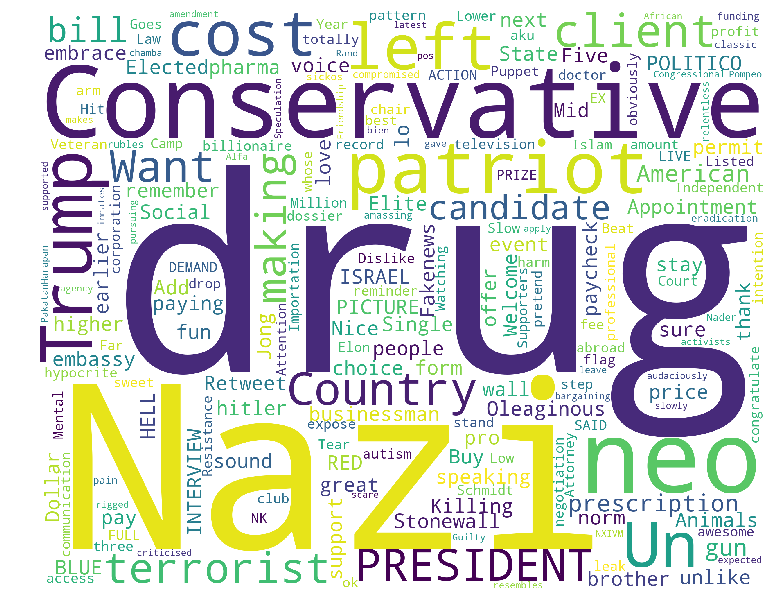

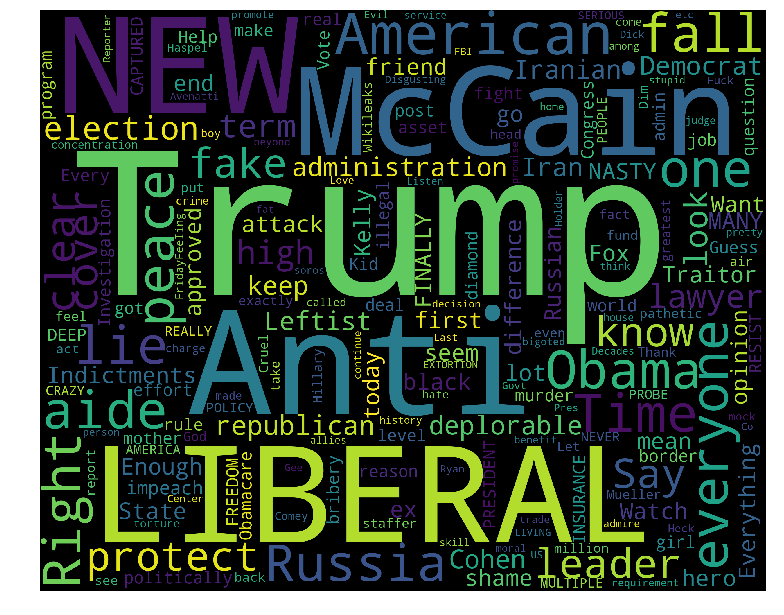

In [75]:
from wordcloud import WordCloud


def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

pos_term = [terms[0] for terms in semantic_sorted if terms[1] > 0 
            and not terms[0].startswith('@')]

neg_term = [terms[0] for terms in semantic_sorted if terms[1] < 0 
            and not terms[0].startswith('@')]

neutral_term = [terms[0] for terms in semantic_sorted if terms[1] == 0 
            and not terms[0].startswith('@')]

wordcloud_draw(pos_term, 'white')
wordcloud_draw(neg_term)




In [76]:
count = 0
target = []
for tweet in original_tweets:
    score = 0
    pos_counter = 0
    neg_counter = 0
    for word in semantic_sorted:
        if word[0].lower() in tweet.lower() and not word[0].isdigit() and len(word[0]) >= 3:
#             print(word)
            if word[1] > 0:
                pos_counter += 1
            if word[1] < 0:
                neg_counter += 1
        
            score += word[1]
    if(pos_counter > neg_counter or score > 0):
        count += 1
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'
    target.append(sentiment)

In [77]:
print(count)
print(len(original_tweets))
print(len(target))

28
3369
3369


In [78]:
# We create a pandas dataframe as follows:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df = pd.DataFrame(data=[tweet for tweet in original_tweets], columns=['text'])
df['sentiment']  = np.array([sentiment for sentiment in target])

In [79]:
import re
from textblob import TextBlob


def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
#     print(clean_tweet(tweet))
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    else:
        return 'Negative'
    

# We create a column with the result of the analysis:
df['SA'] = np.array([ analize_sentiment(tweet) for tweet in df['text'] ])

# We display the updated dataframe with the new column:
display(df[['text', 'SA']].head())

pos_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Positive']
neg_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Negative']


print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['text'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(df['text'])))

,text,SA
0,New #Deconstructed podcast: Did Donald Trump just take us one step closer to war with Iran? Featuring @TVietor08 and @mehdirhasan\nhttps://t.co/pgPGxwsWt3,Positive
1,@MalcolmNance Oh there will be things named after Trump...prisons. #LastWord,Negative
2,"Iran's supreme leader trolls Trump with photo of himself reading ""Fire and Fury"" days after Trump ends nuclear deal https://t.co/Rmv3IZq0hU https://t.co/7pk8vHzgrP",Negative
3,LOL the damn truth hurts....\nPresident Donald Trump Attacks Stop After Michael Avenatti Revelation | ... https://t.co/HgRoaqVNyw via @YouTube,Positive
4,🔴EXTORTION PLOT: Women Sexually Assaulted by Schneiderman Turned to Trump &amp; Cohen in 2013; Then Schneiderman Targeted Trump\n\nNY AG Schneiderman wanted to unseat President Trump from the White House to keep his sexual assault of women a secret.\n https://t.co/SmF1LHW1as,Positive


Percentage of positive tweets: 43.51439596319383%
Percentage de negative tweets: 56.48560403680617%


In [80]:
df.head()

,text,sentiment,SA
0,New #Deconstructed podcast: Did Donald Trump just take us one step closer to war with Iran? Featuring @TVietor08 and @mehdirhasan\nhttps://t.co/pgPGxwsWt3,Negative,Positive
1,@MalcolmNance Oh there will be things named after Trump...prisons. #LastWord,Negative,Negative
2,"Iran's supreme leader trolls Trump with photo of himself reading ""Fire and Fury"" days after Trump ends nuclear deal https://t.co/Rmv3IZq0hU https://t.co/7pk8vHzgrP",Negative,Negative
3,LOL the damn truth hurts....\nPresident Donald Trump Attacks Stop After Michael Avenatti Revelation | ... https://t.co/HgRoaqVNyw via @YouTube,Negative,Positive
4,🔴EXTORTION PLOT: Women Sexually Assaulted by Schneiderman Turned to Trump &amp; Cohen in 2013; Then Schneiderman Targeted Trump\n\nNY AG Schneiderman wanted to unseat President Trump from the White House to keep his sexual assault of women a secret.\n https://t.co/SmF1LHW1as,Negative,Positive


In [81]:
import re, nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens if len(l) >= 3]
    filtered_result = list(filter(lambda l: l not in stop, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [82]:
df['normalized_tweet'] = df.text.apply(normalizer)
df[['text','normalized_tweet']].head(10)

,text,normalized_tweet
0,New #Deconstructed podcast: Did Donald Trump just take us one step closer to war with Iran? Featuring @TVietor08 and @mehdirhasan\nhttps://t.co/pgPGxwsWt3,"[podcast, donald, trump, take, one, step, closer, war, iran, featuring]"
1,@MalcolmNance Oh there will be things named after Trump...prisons. #LastWord,"[thing, named, trump, prison, lastword]"
2,"Iran's supreme leader trolls Trump with photo of himself reading ""Fire and Fury"" days after Trump ends nuclear deal https://t.co/Rmv3IZq0hU https://t.co/7pk8vHzgrP","[supreme, leader, troll, trump, photo, reading, fire, fury, day, trump, end, nuclear, deal]"
3,LOL the damn truth hurts....\nPresident Donald Trump Attacks Stop After Michael Avenatti Revelation | ... https://t.co/HgRoaqVNyw via @YouTube,"[damn, truth, hurt, president, donald, trump, attack, stop, michael, avenatti, revelation]"
4,🔴EXTORTION PLOT: Women Sexually Assaulted by Schneiderman Turned to Trump &amp; Cohen in 2013; Then Schneiderman Targeted Trump\n\nNY AG Schneiderman wanted to unseat President Trump from the White House to keep his sexual assault of women a secret.\n https://t.co/SmF1LHW1as,"[woman, sexually, assaulted, schneiderman, turned, trump, amp, cohen, 2013, schneiderman, targeted, trump, schneiderman, wanted, unseat, president, trump, white, house, keep, sexual, assault, woman, secret]"
5,"@Robbin_Young @StormyDaniels @MichaelAvenatti This is about Trump being gutter trash, not them, you’ve got it backwards... https://t.co/RwAsMurqD2","[trump, gutter, trash, got, backwards]"
6,This lawyer claims he told Trump and Cohen about sexual misconduct by Schneiderman back in 2013 because he believed the DA would not prosecute.\n\nIt’s very hard to believe an attorney would learn of a sexual misconduct and turn to Donald Trump for help instead of law enforcement. https://t.co/rzjSAheEk4,"[claim, told, trump, cohen, sexual, misconduct, schneiderman, back, 2013, believed, would, prosecute, hard, believe, attorney, would, learn, sexual, misconduct, turn, donald, trump, help, instead, law, enforcement]"
7,"If you ever wonder what kind of knee-jerk stupidity we're up against, just remember 41% of Trump supporters polled said they were in favor of bombing Agrabah.\n\nThat's the fictional country from Aladdin. https://t.co/QugIhvQZu6","[ever, wonder, kind, knee, jerk, stupidity, remember, trump, supporter, polled, said, favor, bombing, agrabah, fictional, country, aladdin]"
8,"Donald Trump says he's embarrassed when world leaders come to visit him, because the first thing they ask about is the investigation into his criminal scandals. He's going to be really embarrassed when people come to visit him in prison.","[say, embarrassed, world, leader, come, visit, first, thing, ask, investigation, criminal, scandal, going, really, embarrassed, people, come, visit, prison]"
9,"When American hostage Otto Warmbier was returned from North Korea — he was blind, deaf, and died days later.\n\nIn discussing the released American hostages, Trump says,\n\n“We want to thank Kim Jong-un, who really was excellent to these three incredible people.” \n\nDeplorable. https://t.co/Pwytm387rR","[hostage, otto, warmbier, returned, north, korea, blind, deaf, died, day, later, discussing, released, american, hostage, trump, say, want, thank, kim, jong, really, excellent, three, incredible, people, deplorable]"


In [83]:
import pickle

def load_pickle(file_name):
    with open(file_name + '.pickle', 'rb') as file:
        classifier = pickle.load(file)
    return classifier

In [84]:
classifier = load_pickle('vec_clf')

In [85]:
# classifier.score(data_test, targets_test)
# predicted = classifier.predict(vectorized_data)
print(classifier)
def sentiment2target(sentiment):
    return {
        'Negative': 0,
        'Positive' : 1
    }[sentiment]

# Convert Classification into integer for speed and space efficiency reasons
targets_SA = df.SA.apply(sentiment2target)
targets_sentiment = df.sentiment.apply(sentiment2target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [86]:
predicted = classifier.predict(df.text)

In [87]:
np.mean(predicted == targets_SA)

0.5859305431878896

In [88]:
np.mean(predicted == targets_sentiment)

0.9516176907094093

In [89]:
count_pre = 0
count_pos = 0
for pre in predicted:
    if pre == 1:
        count_pos += 1
        print(df.text[count_pre])
        print("")
    count_pre += 1

I’m driving in #Jerusalem right now and this is what it looks like! 

There are “Trump Make #Israel Great” signs on the traffic lights, &amp; American flags flying next to Israeli flags all around the capital of Israel! 

It’s an incredible sight to see! Thank you @realDonaldTrump! https://t.co/dbaSSL0QkN

@JeffreyGuterman I think Donald the Trump thought he was on Bill and Ted's Excellent Adventure and Kim Jong-un was really Excellent to people and not Bogus as he really is

Mike Pence: “It’s time to wrap up the Mueller investigation.”

— Trump campaign had 70 contacts &amp; 22 meetings w/ Russia.

— 13 Russians indicted &amp; 3 Trump advisors have pled guilty.

— Trump fired Comey &amp; confessed it was b/c of Russia.

It’s time to wrap up the Trump presidency.

Thanks to JW's efforts holding Special Counsel Mueller accountable, JW found docs showing bias among DOJ officials like Andrew Weissmann (top prosecutor on the Mueller team) praising Obama DOJ holdover Sally Yates for lawless

In [90]:
print(count_pre)
print(count_pos)

3369
135
